In [1]:
import pandas as pd


In [2]:
import numpy as np
import pdb
import pywt
from scipy.ndimage import convolve1d

In [3]:
def upArrow_op(li, j):
    if j == 0:
        return [1]
    N = len(li)
    li_n = np.zeros(2**(j - 1) * (N - 1) + 1)
    for i in range(N):
        li_n[2**(j - 1) * i] = li[i]
    return li_n


def period_list(li, N):
    n = len(li)
    # append [0 0 ...]
    n_app = N - np.mod(n, N)
    li = list(li)
    li = li + [0] * n_app
    if len(li) < 2 * N:
        return np.array(li)
    else:
        li = np.array(li)
        li = np.reshape(li, [-1, N])
        li = np.sum(li, axis=0)
        return li


def circular_convolve_mra(h_j_o, w_j):
    ''' calculate the mra D_j'''
    return convolve1d(w_j,
                      np.flip(h_j_o),
                      mode="wrap",
                      origin=(len(h_j_o) - 1) // 2)


def circular_convolve_d(h_t, v_j_1, j):
    '''
    jth level decomposition
    h_t: \tilde{h} = h / sqrt(2)
    v_j_1: v_{j-1}, the (j-1)th scale coefficients
    return: w_j (or v_j)
    '''
    N = len(v_j_1)
    w_j = np.zeros(N)
    ker = np.zeros(len(h_t) * 2**(j - 1))

    # make kernel
    for i, h in enumerate(h_t):
        ker[i * 2**(j - 1)] = h

    w_j = convolve1d(v_j_1, ker, mode="wrap", origin=-len(ker) // 2)
    return w_j


def circular_convolve_s(h_t, g_t, w_j, v_j, j):
    '''
    (j-1)th level synthesis from w_j, w_j
    see function circular_convolve_d
    '''
    N = len(v_j)

    h_ker = np.zeros(len(h_t) * 2**(j - 1))
    g_ker = np.zeros(len(g_t) * 2**(j - 1))

    for i, (h, g) in enumerate(zip(h_t, g_t)):
        h_ker[i * 2**(j - 1)] = h
        g_ker[i * 2**(j - 1)] = g

    v_j_1 = np.zeros(N)

    v_j_1 = convolve1d(w_j,
                       np.flip(h_ker),
                       mode="wrap",
                       origin=(len(h_ker) - 1) // 2)
    v_j_1 += convolve1d(v_j,
                        np.flip(g_ker),
                        mode="wrap",
                        origin=(len(g_ker) - 1) // 2)
    return v_j_1


def modwt(x, filters, level):
    '''
    filters: 'db1', 'db2', 'haar', ...
    return: see matlab
    '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    wavecoeff = []
    v_j_1 = x
    for j in range(level):
        w = circular_convolve_d(h_t, v_j_1, j + 1)
        v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
        wavecoeff.append(w)
    wavecoeff.append(v_j_1)
    return np.vstack(wavecoeff)


def imodwt(w, filters):
    ''' inverse modwt '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    level = len(w) - 1
    v_j = w[-1]
    for jp in range(level):
        j = level - jp - 1
        v_j = circular_convolve_s(h_t, g_t, w[j], v_j, j + 1)
    return v_j


def modwtmra(w, filters):
    ''' Multiresolution analysis based on MODWT'''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    # D
    level, N = w.shape
    level = level - 1
    D = []
    g_j_part = [1]
    for j in range(level):
        # g_j_part
        g_j_up = upArrow_op(g, j)
        g_j_part = np.convolve(g_j_part, g_j_up)
        # h_j_o
        h_j_up = upArrow_op(h, j + 1)
        h_j = np.convolve(g_j_part, h_j_up)
        h_j_t = h_j / (2**((j + 1) / 2.))
        if j == 0: h_j_t = h / np.sqrt(2)
        h_j_t_o = period_list(h_j_t, N)
        D.append(circular_convolve_mra(h_j_t_o, w[j]))
    # S
    j = level - 1
    g_j_up = upArrow_op(g, j + 1)
    g_j = np.convolve(g_j_part, g_j_up)
    g_j_t = g_j / (2**((j + 1) / 2.))
    g_j_t_o = period_list(g_j_t, N)
    S = circular_convolve_mra(g_j_t_o, w[-1])
    D.append(S)
    return np.vstack(D)


In [4]:
x = pd.read_csv(r"spi_6.csv")

In [5]:
x.isnull().sum()

sl.no.      0
rainfall    0
spi_6       0
dtype: int64

In [6]:
x = x["spi_6"].values

In [7]:
print(x)

[ 0.14  0.55  1.02  1.31  1.31  1.2   0.79  0.44 -0.08 -0.86 -0.76 -0.38
  0.09  0.7   1.23  1.31  1.32  1.21  0.97  0.41 -0.82 -1.35 -1.95 -1.62
 -0.55 -0.02  0.51  0.78  0.89  0.84  0.57  0.27 -0.37 -1.06 -1.62 -1.35
 -0.49  0.39  0.78  0.89  0.88  0.84  0.56 -0.12 -0.98 -1.51 -1.62 -1.56
 -0.96 -0.11  0.45  0.81  0.93  0.93  0.81  0.38 -0.17 -0.93 -1.39 -1.24
  0.01  0.45  0.95  1.12  1.12  1.16  0.7   0.29 -0.6  -1.24 -1.39 -1.67
 -1.03 -0.13  0.25  0.42  0.55  0.56  0.43 -0.11 -0.55 -0.96 -1.47 -1.56
 -0.7  -0.23  0.2   0.41  0.41  0.38  0.07 -0.28 -1.09 -2.05 -2.16 -1.95
 -0.3   0.29  0.84  1.07  1.07  1.06  0.66  0.21 -0.6  -1.56 -1.43 -0.59
  0.07  0.53  0.98  1.26  1.45  1.29  0.99  0.65  0.02 -0.68 -2.3  -2.78
 -0.84  0.02  0.62  0.79  0.83  0.86  0.63  0.12 -0.82 -1.56 -1.67 -1.47
 -0.84  0.    0.67  0.88  0.86  0.82  0.67  0.19 -0.8  -1.73 -1.56 -1.43
 -0.52  0.4   0.88  1.11  1.15  1.11  0.88  0.25 -0.52 -1.51 -2.3  -1.39
 -0.3   0.71  1.11  1.37  1.41  1.35  1.06  0.39 -0

In [8]:
# Step 1: Choose a wavelet
wavelet = 'dmey'  # Example: Dmey wavelet, you can change it to any other wavelet

# Step 2: Determine the maximum decomposition level
def get_max_level(data_length):
    return pywt.dwt_max_level(data_length, wavelet)

In [9]:
data = pd.read_csv(r"spi_6.csv")     # Replace with your non-stationary time series

max_level = get_max_level(len(data))
max_level

2

In [10]:
x.dtype

dtype('float64')

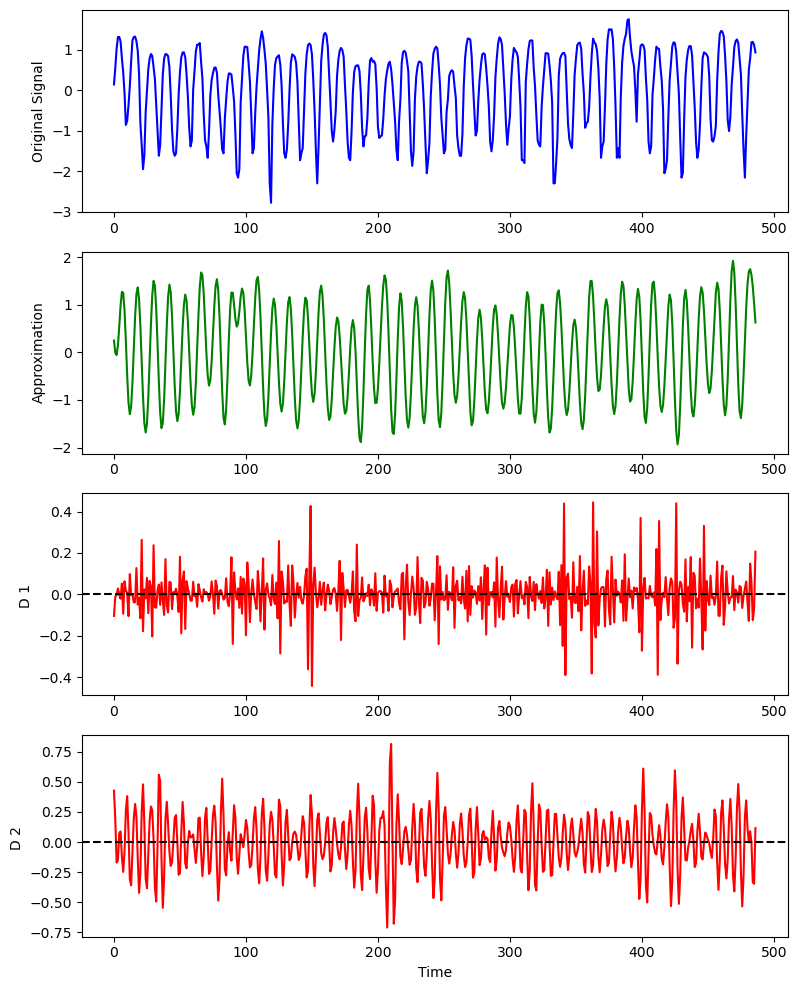

In [11]:
import numpy as np
import matplotlib.pyplot as plt


# Define the wavelet filters
wavelet_filters = 'dmey'  # Replace with the desired wavelet filters

# Define the decomposition level
decomposition_level = 2 # Replace with the desired level

# Perform MODWT
wavelet_coefficients = modwt(x, wavelet_filters, decomposition_level)

# Plot the wavelet coefficients and approximation
fig, ax = plt.subplots(decomposition_level + 2, 1, figsize=(8, 10))

# Plot the original signal
ax[0].plot(x, color='blue')
ax[0].set_ylabel('Original Signal')

# Plot the approximation coefficients
ax[1].plot(wavelet_coefficients[-1], color='green')
ax[1].set_ylabel('Approximation')

# Plot the wavelet coefficients at each level
for i in range(decomposition_level):
    ax[i + 2].plot(wavelet_coefficients[i], color='red')
    ax[i + 2].set_ylabel(f'D {i + 1} ')

    # Plot the zero line for clarity
    ax[i + 2].axhline(0, color='black', linestyle='--')

plt.xlabel('Time')
plt.tight_layout()
plt.savefig('spi_6_khariar_wavelet_all.png', dpi=1200, bbox_inches='tight')
plt.show()

# Prepare data for export
data_export = np.vstack((x, wavelet_coefficients[-1], *wavelet_coefficients[:-1]))

# Define column names
column_names = ['Original Signal', 'Approximation']
column_names += [f'D {i+1}' for i in range(decomposition_level)]

# Export data to CSV
np.savetxt('wavelet_coefficients_dmey.csv', data_export.T, delimiter=',', header=','.join(column_names), comments='')
